# 二维Taylor-Green涡流动

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.0/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r2.0/mindflow/zh_cn/physics_driven/mindspore_taylor_green2D.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.0/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r2.0/mindflow/zh_cn/physics_driven/mindspore_taylor_green2D.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.0/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/r2.0/docs/mindflow/docs/source_zh_cn/physics_driven/taylor_green2D.ipynb)

本案例要求**MindSpore版本 >= 2.0.0**调用如下接口: *mindspore.jit，mindspore.jit_class，mindspore.jacrev*。

## 概述

在流体力学中，Taylor-Green涡流动是一种不稳定的衰减的涡流，在二维周期性边界条件时存在精确解，物理启发的神经网络方法（Physics-informed Neural Networks），以下简称PINNs，通过使用逼近控制方程的损失函数以及简单的网络构型，为快速求解复杂流体问题提供了新的方法。本案例将基于PINNs方法实现二维Taylor-Green涡流动的仿真。

## 二维不可压缩纳维-斯托克斯方程（Navier-Stokes equation）

纳维-斯托克斯方程（Navier-Stokes equation），简称`N-S`方程，是流体力学领域的经典偏微分方程，在粘性不可压缩情况下，无量纲`N-S`方程的形式如下：

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$

$$
\frac{\partial u} {\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = - \frac{\partial p}{\partial x} + \frac{1} {Re} (\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2})
$$

$$
\frac{\partial v} {\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = - \frac{\partial p}{\partial y} + \frac{1} {Re} (\frac{\partial^2v}{\partial x^2} + \frac{\partial^2v}{\partial y^2})
$$

其中，`Re`表示雷诺数。

本案例利用PINNs方法学习位置和时间到相应流场物理量的映射，实现`N-S`方程的求解：

$$
(x, y, t) \mapsto (u, v, p)
$$

## 技术路径

MindSpore Flow求解该问题的具体流程如下：

1. 创建数据集。
2. 构建模型。
3. 优化器。
4. NavierStokes2D。
5. 模型训练。
6. 模型推理及可视化。

## 导入所需要的包

In [1]:
import time
import numpy as np
import sympy
import mindspore
from mindspore import nn, ops, jit, set_seed
from mindspore import numpy as mnp

下述`src`包可以在 [applications/physics_driven/taylor_green/2d/src](https://gitee.com/mindspore/mindscience/tree/r0.2.0/MindFlow/applications/physics_driven/taylor_green/2d/src)下载。

In [ ]:
from mindflow.cell import MultiScaleFCCell
from mindflow.utils import load_yaml_config
from mindflow.pde import NavierStokes, sympy_to_mindspore

from src import create_training_dataset, create_test_dataset, calculate_l2_error, NavierStokes2D

set_seed(123456)
np.random.seed(123456)

下述`taylor_green_2D.yaml`配置文件可以在[applications/physics_driven/taylor_green/2d/taylor_green_2D.yaml](https://gitee.com/mindspore/mindscience/blob/r0.2.0/MindFlow/applications/physics_driven/taylor_green/2d/taylor_green_2D.yaml)下载。

In [ ]:
mindspore.set_context(mode=mindspore.GRAPH_MODE, device_target="GPU", device_id=0, save_graphs=False)
use_ascend = mindspore.get_context(attr_key='device_target') == "Ascend"

config = load_yaml_config('taylor_green_2D.yaml')

## 创建数据集

训练数据集通过create_training_dataset函数导入，数据集分为区域内数据点、初始条件点、边界条件点,即['time_rect_domain_points', 'time_rect_IC_points', 'time_rect_BC_points']，均采用mindflow.geometry相应接口采样，内容在/src/dataset.py中的create_training_dataset函数中。

测试数据集通过create_test_dataset函数导入。本案例使用 [J Kim, P Moin,Application of a fractional-step method to incompressible Navier-Stokes equations,Journal of Computational Physics,Volume 59, Issue 2,1985](https://www.ljll.math.upmc.fr/~frey/papers/Navier-Stokes/KimJ.,%20Application%20of%20a%20fractional%20step%20method%20to%20incompressible%20Navier-Stokes%20equations.pdf)中给出的精确解构建验证集。

本案例考虑一个大小为 $2\pi \times 2\pi$ 的正方形区域在 $t \in (0,2)$ 时段的aylor-Green涡流动仿真。该问题的精确解为：

$$
u(x,y,t) = -cos(x)sin(y)e^{-2t}
$$

$$
v(x,y,t) = sin(x)cos(y)e^{-2t}
$$

$$
p(x,y,t) = -0.25(cos(2x)+cos(2y))e^{-4t}
$$

In [2]:
# create training dataset
taylor_dataset = create_training_dataset(config)
train_dataset = taylor_dataset.create_dataset(batch_size=config["train_batch_size"],
                                              shuffle=True,
                                              prebatched_data=True,
                                              drop_remainder=True)

# create test dataset
inputs, label = create_test_dataset(config)

## 构建模型

本示例使用一个简单的全连接网络，深度为6层，每层128个神经元，激活函数是tanh函数。

In [3]:
coord_min = np.array(config["geometry"]["coord_min"] + [config["geometry"]["time_min"]]).astype(np.float32)
coord_max = np.array(config["geometry"]["coord_max"] + [config["geometry"]["time_max"]]).astype(np.float32)
input_center = list(0.5 * (coord_max + coord_min))
input_scale = list(2.0 / (coord_max - coord_min))

model = MultiScaleFCCell(in_channels=config["model"]["in_channels"],
                         out_channels=config["model"]["out_channels"],
                         layers=config["model"]["layers"],
                         neurons=config["model"]["neurons"],
                         residual=config["model"]["residual"],
                         act='tanh',
                         num_scales=1,
                         input_scale=input_scale,
                         input_center=input_center)

## 优化器

In [5]:
params = model.trainable_params()
optimizer = nn.Adam(params, learning_rate=config["optimizer"]["initial_lr"])

## NavierStokes2D

下述NavierStokes2D将圆柱绕流问题同数据集关联起来，包含3个部分：控制方程，边界条件和初始条件。控制方程在mindflow.pde中实现，边界条件与初始条件也是根据上述论文中的解析解实现。

In [6]:
class NavierStokes2D(NavierStokes):
    def __init__(self, model, re=100, loss_fn=nn.MSELoss()):
        super(NavierStokes2D, self).__init__(model, re=re, loss_fn=loss_fn)
        self.ic_nodes = sympy_to_mindspore(self.ic(), self.in_vars, self.out_vars)
        self.bc_nodes = sympy_to_mindspore(self.bc(), self.in_vars, self.out_vars)

    def ic(self):
        """
        Define initial condition equations based on sympy, abstract method.
        """
        ic_u = self.u + sympy.cos(self.x) * sympy.sin(self.y)
        ic_v = self.v - sympy.sin(self.x) * sympy.cos(self.y)
        ic_p = self.p + 0.25 * (sympy.cos(2*self.x) + sympy.cos(2*self.y))
        equations = {"ic_u": ic_u, "ic_v": ic_v, "ic_p": ic_p}
        return equations

    def bc(self):
        """
        Define boundary condition equations based on sympy, abstract method.
        """
        bc_u = self.u + sympy.cos(self.x) * sympy.sin(self.y) * sympy.exp(-2*self.t)
        bc_v = self.v - sympy.sin(self.x) * sympy.cos(self.y) * sympy.exp(-2*self.t)
        bc_p = self.p + 0.25 * (sympy.cos(2*self.x) + sympy.cos(2*self.y)) * sympy.exp(-4*self.t)
        equations = {"bc_u": bc_u, "bc_v": bc_v, "bc_p": bc_p}
        return equations

    def get_loss(self, pde_data, ic_data, bc_data):
        """
        Compute loss of 3 parts: governing equation, initial condition and boundary conditions.

        Args:
            pde_data (Tensor): the input data of governing equations.
            ic_data (Tensor): the input data of initial condition.
            bc_data (Tensor): the input data of boundary condition.
        """
        pde_res = self.parse_node(self.pde_nodes, inputs=pde_data)
        pde_residual = ops.Concat(1)(pde_res)
        pde_loss = self.loss_fn(pde_residual, mnp.zeros_like(pde_residual))

        ic_res = self.parse_node(self.ic_nodes, inputs=ic_data)
        ic_residual = ops.Concat(1)(ic_res)
        ic_loss = self.loss_fn(ic_residual, mnp.zeros_like(ic_residual))

        bc_res = self.parse_node(self.bc_nodes, inputs=bc_data)
        bc_residual = ops.Concat(1)(bc_res)
        bc_loss = self.loss_fn(bc_residual, mnp.zeros_like(bc_residual))

        return pde_loss + ic_loss + bc_loss

## 模型训练

使用MindSpore>= 2.0.0的版本，可以使用函数式编程范式训练神经网络。

In [7]:
def train():
    problem = NavierStokes2D(model, re=config["Re"])

    if use_ascend:
        from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
        loss_scaler = DynamicLossScaler(1024, 2, 100)
        auto_mixed_precision(model, 'O3')

    def forward_fn(pde_data, ic_data, bc_data):
        loss = problem.get_loss(pde_data, ic_data, bc_data)
        if use_ascend:
            loss = loss_scaler.scale(loss)
        return loss

    grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

    @jit
    def train_step(pde_data, ic_data, bc_data):
        loss, grads = grad_fn(pde_data, ic_data, bc_data)
        if use_ascend:
            loss = loss_scaler.unscale(loss)
            if all_finite(grads):
                grads = loss_scaler.unscale(grads)
                loss = ops.depend(loss, optimizer(grads))
        else:
            loss = ops.depend(loss, optimizer(grads))
        return loss

    epochs = config["train_epochs"]
    steps_per_epochs = train_dataset.get_dataset_size()
    sink_process = mindspore.data_sink(train_step, train_dataset, sink_size=1)
    for epoch in range(1, 1 + epochs):
        # train
        time_beg = time.time()
        model.set_train(True)
        for _ in range(steps_per_epochs):
            step_train_loss = sink_process()
        model.set_train(False)

        if epoch % config["eval_interval_epochs"] == 0:
            print(f"epoch: {epoch} train loss: {step_train_loss} epoch time: {(time.time() - time_beg) * 1000 :.3f} ms")
            calculate_l2_error(model, inputs, label, config)

In [ ]:
start_time = time.time()
train()
print("End-to-End total time: {} s".format(time.time() - start_time))

momentum_x: u(x, y, t)*Derivative(u(x, y, t), x) + v(x, y, t)*Derivative(u(x, y, t), y) + Derivative(p(x, y, t), x) + Derivative(u(x, y, t), t) - 1.0*Derivative(u(x, y, t), (x, 2)) - 1.0*Derivative(u(x, y, t), (y, 2))
    Item numbers of current derivative formula nodes: 6
momentum_y: u(x, y, t)*Derivative(v(x, y, t), x) + v(x, y, t)*Derivative(v(x, y, t), y) + Derivative(p(x, y, t), y) + Derivative(v(x, y, t), t) - 1.0*Derivative(v(x, y, t), (x, 2)) - 1.0*Derivative(v(x, y, t), (y, 2))
    Item numbers of current derivative formula nodes: 6
continuty: Derivative(u(x, y, t), x) + Derivative(v(x, y, t), y)
    Item numbers of current derivative formula nodes: 2
ic_u: u(x, y, t) + sin(y)*cos(x)
    Item numbers of current derivative formula nodes: 2
ic_v: v(x, y, t) - sin(x)*cos(y)
    Item numbers of current derivative formula nodes: 2
ic_p: p(x, y, t) + 0.25*cos(2*x) + 0.25*cos(2*y)
    Item numbers of current derivative formula nodes: 3
bc_u: u(x, y, t) + exp(-2*t)*sin(y)*cos(x)
    I

## 模型推理及可视化

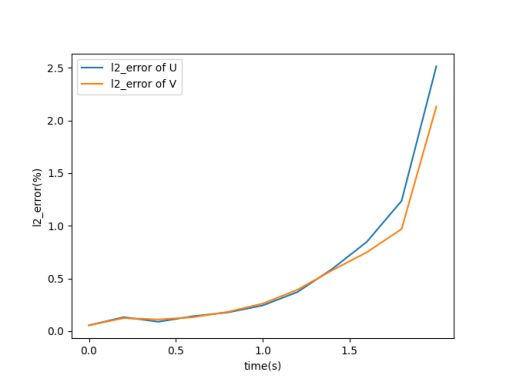

In [ ]:
from src import visual

# visualization
visual(model=model, epoch=config["train_epochs"], input_data=inputs, label=label)

因速度呈指数下降的趋势，随着时间推移，误差变大，但整体处于5%的误差范围内。